In [29]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import requests
import QuantLib as ql
import numpy as np
import json
from tradingview_screener import Query, col
import rookiepy
from sklearn.preprocessing import MinMaxScaler
import gbm_optimizer
from gbm_optimizer import optimize_gbm, gbm
import matplotlib.pyplot as plt
from arch import arch_model

import importlib
importlib.reload(gbm_optimizer)


with open("config.json", "r") as config_file:
    config = json.load(config_file)

api_key = config.get("api_key")
secret_key = config.get("secret_key")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

our_picks = ["CHWY", "IBIT", "ASO", "MARA", "SMCI", "TEM", "PIN", "HIMS", "ET", "DVN", "INTC", "SPLG"]



In [30]:
    
def screen_stocks():
    # Get cookies for TradingView session
    cookies = rookiepy.to_cookiejar(rookiepy.chrome(['.tradingview.com']))
    
    _, df = Query().select('close','change', 'Perf.3M', 'Perf.6M').where(
        col('close').between(20, 50),
        col('change').between(-4,-2),
        col('Perf.3M') > 0,
        col('Perf.6M') > 5,
        col('exchange').isin(['AMEX', 'NASDAQ', 'NYSE']),

        ).limit(1000).get_scanner_data(cookies=cookies)
    
    df[['exchange', 'ticker']] = df['ticker'].str.split(':', expand=True)
    
    return df


def get_rolling_price_change_avg(ticker: str, days: int):
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days+10)
        
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        if data.empty:
            return None
        
        data = data.sort_index()
        current_price = get_current_stock_price(ticker)

        data['Price_Change'] = ((current_price - data['Close'].shift(1)) / data['Close'].shift(1)) * 100

        rolling_avg = data['Price_Change'].rolling(window=min(days, len(data))).mean().iloc[-1]

        return rolling_avg
    
    except Exception as e:
        print(f"Error occurred for ticker {ticker}: {e}")
        return None, None


def get_open_interest(api_key: str, secret_key: str, option_symbol: str):
    """Fetches open interest for a given option contract using Alpaca's Trading API."""
    url = f"https://paper-api.alpaca.markets/v2/options/contracts/{option_symbol}"
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": api_key,
        "APCA-API-SECRET-KEY": secret_key,
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        return data.get("open_interest")  # Extract OI if available
    except requests.exceptions.RequestException as e:
        print(f"Error fetching open interest for {option_symbol}: {e}")
        return None
    

def get_current_stock_price(symbol: str):

    url = "https://data.alpaca.markets/v2/stocks/trades/latest"

    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": api_key,
        "APCA-API-SECRET-KEY": secret_key,
    }

    params = {
        "symbols": symbol,  
        "feed": "iex" 
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  

        data = response.json()

        return data.get("trades", {}).get(symbol, {}).get("p") 

    except requests.exceptions.RequestException as e:
        print(f"Error fetching stock price: {e}")


def get_option_chain(api_key: str, secret_key: str, ticker: str, expiration_date: datetime):
    expiration_str = expiration_date.strftime("%Y-%m-%d")  
    data = yf.download(tickers=ticker, period="6mo", interval="1d", progress=False)

    if len(data) == 0:
        return None
    
    url = f"https://data.alpaca.markets/v1beta1/options/snapshots/{ticker}?feed=indicative&limit=100&expiration_date={expiration_str}"
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": api_key,
        "APCA-API-SECRET-KEY": secret_key,
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        option_chain = data.get("snapshots", {})

        if not option_chain:
            return None

        parsed_data = []
        for symbol, details in option_chain.items():
            expiration_start = len(symbol) - 15
            option_type = "Call" if symbol[expiration_start+6] == "C" else "Put"
            strike_price = int(symbol[expiration_start+7:]) / 1000  

            greeks = details.get("greeks", {}) or {}
            latest_quote = details.get("latestQuote", {})

            returned = ((latest_quote.get("ap") + latest_quote.get("bp") / 2) / strike_price) * 100
            
            if latest_quote.get("bp") != 0 and latest_quote.get("ap") != 0:
                if (((latest_quote.get("ap") - latest_quote.get("bp")) / latest_quote.get("bp")) * 100 > 30) or greeks.get("rho") is None or returned < 0.5 or returned > 2.0:
                    continue
                
            open_interest = get_open_interest(api_key, secret_key, symbol)
            open_interest = int(open_interest) if open_interest is not None else 0

            if (open_interest < 40):
                continue
            
        
            parsed_data.append({
                "symbol": ticker,
                "expiration_date": expiration_str,  
                "option_type": option_type,
                "delta": greeks.get("delta"),
                "gamma": greeks.get("gamma"),
                "rho": greeks.get("rho"),
                "theta": greeks.get("theta"),
                "vega": greeks.get("vega"),
                "implied_volatility": details.get("impliedVolatility"),
                "ask_price": latest_quote.get("ap"),
                "ask_size": latest_quote.get("as"),
                "bid_price": latest_quote.get("bp"),
                "bid_size": latest_quote.get("bs"),
                "open_interest": open_interest,
                "strike_price": strike_price 

            })

        df = pd.DataFrame(parsed_data)
        df = df[(df['option_type'] == 'Put') & (df['delta'].notna())]
        return df
    
        return pd.DataFrame(parsed_data)

    except requests.exceptions.RequestException as e:
        print(f"Error fetching option chain: {e}")
        return None


def select_optimal_contract(contracts):
    """Compute the weighted score for contracts using normalized values."""
    temp_contracts = contracts.copy()
    
    scaler = MinMaxScaler()
    temp_contracts[['profitability_likelihood', 'return_percent', 'sortino_ratio']] = scaler.fit_transform(
        temp_contracts[['profitability_likelihood', 'return_percent', 'sortino_ratio']]
    )
    
    temp_contracts['score'] = (
        0.60 * temp_contracts['profitability_likelihood'] +
        0.40 * temp_contracts['return_percent'] +
        0.10 * temp_contracts['sortino_ratio']
    )
    
    contracts['score'] = temp_contracts['score']
    
    return contracts.sort_values(by='score', ascending=False)


def audit_csps(expiration_date: datetime):
    # t-bill 3-month rate: 4.19% and inflation: 2.9%, scaled to daily compounding
    daily_risk_free_rate = (1 + 0.0419) ** (1/252) - 1  # No inflation adjustment

    # function hyperparameters
    simulation_attempts = 300
    optimizer_training_period = "6mo"
    bin_length = 18
    days_to_expiration = np.busday_count(datetime.today().date(), expiration_date.date())

    all_options = []  
    
    candidates = screen_stocks()['ticker'].to_list()
    candidates.extend(our_picks)    

    print(f"Consider {len(candidates)} stocks")

    for symbol in candidates:
        option_chain = get_option_chain(api_key=api_key, secret_key=secret_key, ticker=symbol, expiration_date=expiration_date)

        if option_chain is None or option_chain.empty:
            continue


        price = get_current_stock_price(symbol)
        optimized_mu, optimized_sigma = optimize_gbm(symbol=symbol, training_period=optimizer_training_period, bin_length=bin_length)
        optimized_sigma = fit_garch(symbol=symbol, period=optimizer_training_period)

        gbm_vs_real_graph(symbol=symbol, mu=optimized_mu, sigma=optimized_sigma, period=optimizer_training_period)

        put_chain_copy = option_chain.copy()

        for index, contract in put_chain_copy.iterrows():
            strike_price = contract['strike_price']
            premium_collected = (contract['bid_price'] + contract['ask_price']) / 2
            simulated_returns = []
            simulated_final_prices = []
            profitable_count = 0

            # Run simulations

            for _ in range(simulation_attempts):
                prices = gbm(
                    s0=price, mu=optimized_mu, sigma=optimized_sigma, 
                    deltaT=days_to_expiration, 
                    dt=1
                )
                final_price = prices[-1]
                # option expires worthless (or at-the-money), seller keeps premium.
                if final_price >= strike_price:
                    profitable_count += 1
                    net_return = (premium_collected / strike_price) * 100
                else:
                    # assigned, the net return is: premium - (loss from assignment)
                    net_return = ((premium_collected - (strike_price - final_price)) / strike_price) * 100

                simulated_returns.append(net_return)
                simulated_final_prices.append(prices[-1])

            profitability_chance = (profitable_count / simulation_attempts) * 100
            percent_return = (premium_collected / strike_price) * 100  
            avg_return = np.mean(simulated_returns)
            avg_price = np.mean(simulated_final_prices)
            
            risk_free_return = daily_risk_free_rate * days_to_expiration
            # Downside returns: only include simulated returns that are below the target.
            downside_returns = [r for r in simulated_returns if r < risk_free_return]
            if len(downside_returns) > 1:
                downside_std = np.std(downside_returns, ddof=1)
            else:
                downside_std = 0

            # Annualize the ratio (using sqrt(252/days_to_expiration))
            if downside_std != 0:
                sortino_ratio = ((avg_return - risk_free_return) / downside_std) * np.sqrt(252 / days_to_expiration)
            else:
                sortino_ratio = 0

            put_chain_copy.at[index, 'fill_price'] = premium_collected
            put_chain_copy.at[index, 'current_price'] = price
            put_chain_copy.at[index, 'final_price'] = avg_price
            put_chain_copy.at[index, 'profitability_likelihood'] = profitability_chance
            put_chain_copy.at[index, 'return_percent'] = percent_return
            put_chain_copy.at[index, 'average_return'] = avg_return
            put_chain_copy.at[index, 'sortino_ratio'] = sortino_ratio

        all_options.append(put_chain_copy)

    # Concatenate all DataFrames in the list once at the end
    return pd.concat(all_options, ignore_index=True)


def analyze_equity_puts(ticker: str, expiration_date: datetime):
    # T-bill 3-month rate: 4.19% and inflation: 2.9%, scaled to daily compounding
    daily_risk_free_rate = ((1 + 0.0419) / (1 + 0.029)) ** (1/252) - 1

    simulation_attempts = 300
    optimizer_training_period = "6mo"
    bin_length = 18
    days_to_expiration = np.busday_count(datetime.today().date(), expiration_date.date())

    option_chain = get_option_chain(api_key=api_key, secret_key=secret_key, ticker=ticker, expiration_date=expiration_date)

    if option_chain is None or option_chain.empty:
        return pd.DataFrame()  

    put_chain = option_chain[
        (option_chain['option_type'] == 'Put') & (option_chain['rho'].notna())
    ].sort_values(by='strike_price', ascending=True)

    if len(put_chain) == 0:
        return pd.DataFrame()  
    
    price = get_current_stock_price(ticker)

    optimized_mu, optimized_sigma = optimize_gbm(symbol=ticker, training_period=optimizer_training_period, bin_length=bin_length)
    optimized_sigma = fit_garch(symbol=ticker, period=optimizer_training_period)

    gbm_vs_real_graph(symbol=ticker, mu=optimized_mu, sigma=optimized_sigma, period=optimizer_training_period)

    put_chain_copy = put_chain.copy()

    for index, contract in put_chain_copy.iterrows():
        strike_price = contract['strike_price']
        premium_collected = (contract['bid_price'] + contract['ask_price']) / 2
        simulated_returns = []
        simulated_final_prices = []
        profitable_count = 0

        for _ in range(simulation_attempts):
            prices = gbm(
                s0=price, mu=optimized_mu, sigma=optimized_sigma, 
                deltaT=days_to_expiration, 
                dt=1
            )
            final_price = prices[-1]

            # Option expires worthless (or at-the-money), seller keeps premium
            if final_price >= strike_price:
                profitable_count += 1
                net_return = (premium_collected / strike_price) * 100
            else:
                # Assigned, the net return is: premium - (loss from assignment)
                net_return = ((premium_collected - (strike_price - final_price)) / strike_price) * 100

            simulated_returns.append(net_return)
            simulated_final_prices.append(prices[-1])

        profitability_chance = (profitable_count / simulation_attempts) * 100
        percent_return = (premium_collected / strike_price) * 100
        avg_return = np.mean(simulated_returns)
        avg_price = np.mean(simulated_final_prices)

        risk_free_return = daily_risk_free_rate * days_to_expiration
        downside_returns = [r for r in simulated_returns if r < risk_free_return]
        if len(downside_returns) > 1:
            downside_std = np.std(downside_returns, ddof=1)
        else:
            downside_std = 0

        if downside_std != 0:
            sortino_ratio = ((avg_return - risk_free_return) / downside_std) * np.sqrt(252 / days_to_expiration)
        else:
            sortino_ratio = 0

        put_chain_copy.at[index, 'fill_price'] = premium_collected
        put_chain_copy.at[index, 'current_price'] = price
        put_chain_copy.at[index, 'final_price'] = avg_price
        put_chain_copy.at[index, 'profitability_likelihood'] = profitability_chance
        put_chain_copy.at[index, 'return_percent'] = percent_return
        put_chain_copy.at[index, 'average_return'] = avg_return
        put_chain_copy.at[index, 'sortino_ratio'] = sortino_ratio

    put_chain_copy = put_chain_copy.drop(labels=['delta', 'gamma', 'rho','theta','vega','implied_volatility'], axis=1 )
    cols = list(put_chain_copy.columns)
    cols.insert(cols.index("fill_price") + 1, cols.pop(cols.index("strike_price")))
    put_chain_copy = put_chain_copy[cols]

    return put_chain_copy

def gbm_vs_real_graph(symbol, mu, sigma, period):
    stock_data = yf.download(symbol, period=period, interval="1d", progress=False)
    real_prices = stock_data["Close"].dropna().values
    time_steps = np.arange(len(real_prices))


    gbm_path = gbm(s0 = real_prices[0], mu=mu, sigma=sigma, deltaT=len(real_prices), dt=1)
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, real_prices, label="Real Prices", color="blue")
    plt.plot(time_steps, gbm_path, label="GBM Simulated", linestyle="dashed", color="red")
    
    plt.xlabel("Time (Days)")
    plt.ylabel("Price")
    plt.title(f"GBM vs Real Prices for {symbol}")
    plt.legend()
    plt.grid()
    plt.show()

def fit_garch(symbol, period):
    stock_data = yf.download(symbol, period=period, interval="1d", progress=False)
    real_prices = stock_data["Close"].dropna().values.flatten()
    returns = np.diff(np.log(real_prices))
    
    # Fit GARCH(1,1) model
    model = arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
    garch_fit = model.fit(disp="off")
    
    conditional_volatilities = garch_fit.conditional_volatility

    N = len(conditional_volatilities)
    weights = np.linspace(1, 2, N)  

    weighted_volatility = np.sum(weights * conditional_volatilities) / np.sum(weights)

    return weighted_volatility


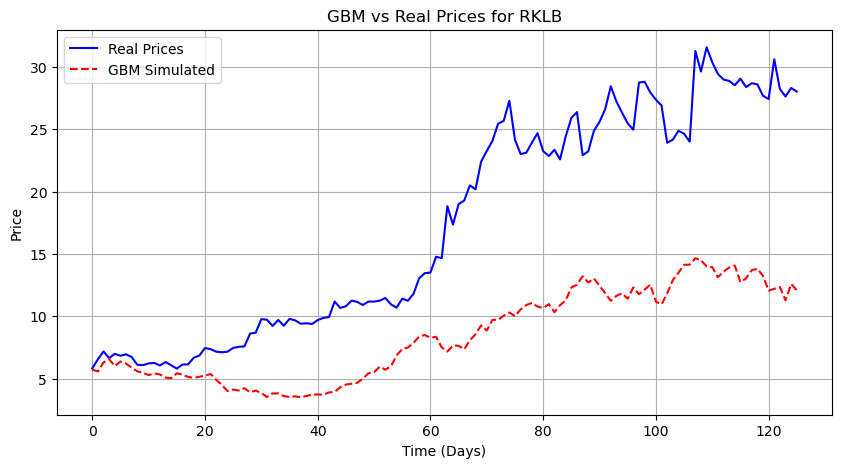

In [31]:
# Analyze a bunch of stocks
# contracts = audit_csps(expiration_date = datetime(year=2025, month=2, day=21))

# Analyze one stock
contracts = analyze_equity_puts(ticker="RKLB", expiration_date=datetime(year=2025, month=2, day=21))

In [32]:
contracts = select_optimal_contract(contracts)

display(contracts)

,symbol,expiration_date,option_type,ask_price,ask_size,bid_price,bid_size,open_interest,fill_price,current_price,strike_price,final_price,profitability_likelihood,return_percent,average_return,sortino_ratio,score
16,RKLB,2025-02-21,Put,0.18,78,0.15,63,2432,0.165,28.01,24.5,29.306948,93.666667,0.673469,0.301897,0.562549,0.704165
8,RKLB,2025-02-21,Put,0.13,68,0.11,16,1709,0.120,28.01,24.0,29.572559,95.000000,0.500000,0.251454,0.439242,0.600000
13,RKLB,2025-02-21,Put,0.30,175,0.26,1,412,0.280,28.01,25.5,29.544279,86.333333,1.098039,0.306836,0.592518,0.500000


In [33]:
# Archive

# def fit_garch(symbol, period):
#     stock_data = yf.download(symbol, period=period, interval="1d")
#     real_prices = stock_data["Close"].dropna().values
#     returns = np.diff(np.log(real_prices))
#     model = arch_model(returns, vol='Garch', p=1, q=1)
#     garch_fit = model.fit()
#     return garch_fit.conditional_volatility


# def gbm_vs_real_graph(symbol, mu, sigma, period):
#     stock_data = yf.download(symbol, period=period, interval="1d")
#     real_prices = stock_data["Close"].dropna().values
#     time_steps = np.arange(len(real_prices))


#     gbm_path = gbm(s0 = real_prices[0], mu=mu, sigma=sigma, deltaT=len(real_prices), dt=1)
#     plt.figure(figsize=(10, 5))
#     plt.plot(time_steps, real_prices, label="Real Prices", color="blue")
#     plt.plot(time_steps, gbm_path, label="GBM Simulated", linestyle="dashed", color="red")
    
#     plt.xlabel("Time (Days)")
#     plt.ylabel("Price")
#     plt.title(f"GBM vs Real Prices for {symbol}")
#     plt.legend()
#     plt.grid()
#     plt.show()



# def gbm(s0, mu, sigma, deltaT, dt):
#     """
#     Models a stock price S(t) using the Wiener process W(t) as
#     `S(t) = S(0).exp{(mu-(sigma^2/2).t)+sigma.W(t)}`
    
#     Arguments:
#         s0: Initial stock price, default 100
#         mu: 'Drift' of the stock (upwards or downwards), default 0.2
#         sigma: 'Volatility' of the stock, default 0.68
#         deltaT: The time period for which the future prices are computed, default 52 (as in 52 weeks)
#         dt: The granularity of the time-period, default 0.1
    
#     Returns:
#         time_vector: array of time steps
#         s: array with the simulated stock prices over the time-period deltaT
#     """
#     n_step = int(deltaT / dt)  # Number of time steps
#     time_vector = np.linspace(0, deltaT, num=n_step)  # Time vector
    
#     # Wiener process: cumulative sum of random normal increments
#     random_increments = np.random.normal(0, 1, size=n_step) * np.sqrt(dt)
#     weiner_process = np.cumsum(random_increments)
    
#     # Stock price simulation
#     stock_var = (mu - (sigma**2 / 2)) * time_vector
#     s = s0 * np.exp(stock_var + sigma * weiner_process)
    
#     return s



# def aobjective(params, real_prices, s0):
#     """Objective function for optimization."""
#     mu, sigma = params  # Unpack parameters
#     gbm_prices = gbm(s0, mu, sigma, deltaT=len(real_prices), dt=1)
#     return mean_squared_error(real_prices, gbm_prices)

# def aoptimize_gbm(symbol: str, training_period: str, bin_length: int):
#     """
#     Optimize μ and σ over multiple time bins, weighting recent periods more.
#     """
#     # Fetch real stock data (past 5 years)
#     stock_data = yf.download(symbol, period=training_period, interval="1d")
#     real_prices = stock_data["Close"].dropna().values

#     num_bins = len(real_prices) // bin_length
#     weights = np.linspace(1, 2, num_bins)  # Increasing weights for recent bins

#     mu_values, sigma_values, mses = [], [], []

#     for i in range(num_bins):
#         bin_prices = real_prices[i * bin_length : (i + 1) * bin_length]
#         s0 = bin_prices[0]

#         bounds = [(-0.3, 0.3), (0.001, 0.35)]

#         result = differential_evolution(objective, bounds, args=(bin_prices, s0))
#         best_mu, best_sigma = result.x
#         best_mse = result.fun

#         mu_values.append(best_mu)
#         sigma_values.append(best_sigma)
#         mses.append(best_mse)

#     weight_sum = np.sum(weights)
#     avg_mu = np.sum(np.array(mu_values) * weights) / weight_sum
#     avg_sigma = np.sum(np.array(sigma_values) * weights) / weight_sum

#     print(f"\nFinal Weighted Averages: μ = {avg_mu:.4f}, σ = {avg_sigma:.4f}")

#     return avg_mu, avg_sigma



    # def filter_stocks(rolling_change_period): 
    # filtered_stocks = set()
    # stocks = screen_stocks()

    # for index, stock in stocks.iterrows():
    #     try:
    #         today_change, rolling_avg = get_rolling_price_change_avg(stock['ticker'], days=rolling_change_period)
    #         current_price = get_current_stock_price(stock['ticker'])

    #         # Skip if any value is None
    #         if None in (today_change, rolling_avg, current_price):
    #             print(f"Skipping {stock['ticker']} due to missing data.")
    #             continue

    #         # Apply filtering conditions
    #         if (rolling_avg > 0.00): 
    #             filtered_stocks.add(stock['ticker'])

    #     except Exception as e:
    #         print(f"Skipping {stock['ticker']} due to error: {e}")
    #         continue
    
    # return filtered_stocks

    #def ORIGINAL_LOGIC_FOR _AUDITING_OPTIONS()
    # simulation_attempts = 200
    # optimizer_training_period = "2y"
    # bin_length = 20
    # rolling_change_period = 15
    # expiration_date = datetime(year=2025, month=2, day=14) 
    # all_options = pd.DataFrame(columns=['symbol', 'expiration_date', 'option_type', 'strike_price', 'delta', 'gamma', 'rho', 'theta', 'vega', 'implied_volatility', 'ask_price', 'ask_size', 'bid_price', 'bid_size'])
    # candidates = ["AAPL", "AMD"]
    # # filter_stocks(rolling_change_period=rolling_change_period)

    # # t-bill 3-month rate: 4.19%, inflation rate: 2.9% -> scaled to weekly
    # risk_free_rate = (((1 + 0.0419) / (1 + 0.029)) ** (1/52) - 1) * 100

    # print(candidates)

    # for symbol in candidates:
    #     option_chain = get_option_chain(api_key=api_key, secret_key=secret_key, ticker=symbol, expiration_date=expiration_date)
    #     put_chain = option_chain[(option_chain['option_type'] == 'Put') & (option_chain['rho'].notna())].sort_values(by='strike_price', ascending=True)

    #     if option_chain is None or option_chain.empty:
    #         continue 

    #     price = get_current_stock_price(symbol)
    #     optimized_mu, optimized_sigma = optimize_gbm(symbol=symbol, training_period=optimizer_training_period, bin_length=bin_length)

    #     profitability_chances = []
    #     percent_returns = []

    #     for index, contract in put_chain.iterrows():
    #         count = 0
    #         strike_price = contract['strike_price']

    #         for i in range(simulation_attempts):
    #             prices = gbm(s0=price, mu=optimized_mu, sigma=optimized_sigma, 
    #                 deltaT=np.busday_count(datetime.today().date(), datetime.strptime(contract['expiration_date'], "%Y-%m-%d").date()), dt=1)  
    #             if prices[-1] > strike_price:
    #                 count += 1
    #         profitability_chance = (count / simulation_attempts) * 100
    #         profit = (contract['bid_price']*contract['bid_size'] + contract['ask_price']*contract['ask_size']) / (contract['ask_size'] + contract['bid_size'])
    #         percent_return = (profit / (strike_price)) * 100

    #         profitability_chances.append(profitability_chance)
    #         percent_returns.append(percent_return)
    #     put_chain['profitability_percent'] = profitability_chances
    #     put_chain['percent_return'] = percent_returns
    #     put_chain['expected_value'] = put_chain['profitability_percent'] * put_chain['percent_return']
    #     put_chain['current_price'] = price
    #     if put_chain['percent_return'].std() != 0:
    #         put_chain['sortino_ratio'] = (put_chain['percent_return'] - risk_free_rate) / put_chain['percent_return'].std()
    #     else:
    #         put_chain['sortino_ratio'] = 0  # Avoid division by zero
    #     all_options = pd.concat([all_options, put_chain], ignore_index=True, copy=False)


# def gbm_vs_real_graph(symbol, mu, sigma, period):
#     stock_data = yf.download(symbol, period=period, interval="1d")
#     real_prices = stock_data["Close"].dropna().values
#     time_steps = np.arange(len(real_prices))


#     gbm_path = gbm(s0 = real_prices[0], mu=mu, sigma=sigma, deltaT=len(real_prices), dt=1)
#     plt.figure(figsize=(10, 5))
#     plt.plot(time_steps, real_prices, label="Real Prices", color="blue")
#     plt.plot(time_steps, gbm_path, label="GBM Simulated", linestyle="dashed", color="red")
    
#     plt.xlabel("Time (Days)")
#     plt.ylabel("Price")
#     plt.title(f"GBM vs Real Prices for {symbol}")
#     plt.legend()
#     plt.grid()
#     plt.show()

# def multithread_optimize_bin(bin_prices, bin_size, weights, i):
#     s0 = bin_prices[0]

#     # Define the bounds for optimization
#     bounds = [(-0.3, 0.3), (0.001, 0.30)]

#     # Run the optimizer for the bin
#     result = differential_evolution(objective, bounds, args=(bin_prices, s0))
#     best_mu, best_sigma = result.x
#     best_mse = result.fun

#     print(f"Bin {i+1}: μ = {best_mu:.4f}, σ = {best_sigma:.4f}, MSE = {best_mse:.4f}")
#     return best_mu, best_sigma, best_mse

# def multithread_optimize_gbm(symbol): 
    # """
    # Optimize μ and σ over multiple time bins, weighting recent periods more.
    # """
    # # Fetch real stock data (past 2 years)
    # stock_data = yf.download(symbol, period="2y", interval="1d")
    # real_prices = stock_data["Close"].dropna().values

    # # Split into bins of 20 trading days
    # bin_size = 20
    # num_bins = len(real_prices) // bin_size
    # weights = np.linspace(1, 2, num_bins)  # Increasing weights for recent bins

    # # Initialize containers for results
    # mu_values, sigma_values, mses = [], [], []

    # # Use concurrent.futures for parallel processing of bins
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #     futures = []
    #     for i in range(num_bins):
    #         bin_prices = real_prices[i * bin_size : (i + 1) * bin_size]
    #         futures.append(executor.submit(optimize_bin, bin_prices, bin_size, weights, i))
        
    #     for future in concurrent.futures.as_completed(futures):
    #         best_mu, best_sigma, best_mse = future.result()
    #         mu_values.append(best_mu)
    #         sigma_values.append(best_sigma)
    #         mses.append(best_mse)

    # # Compute weighted averages
    # weight_sum = np.sum(weights)
    # avg_mu = np.sum(np.array(mu_values) * weights) / weight_sum
    # avg_sigma = np.sum(np.array(sigma_values) * weights) / weight_sum

    # print(f"\nFinal Weighted Averages: μ = {avg_mu:.4f}, σ = {avg_sigma:.4f}")

    # return avg_mu, avg_sigma

# NASDAQ = pd.read_csv('Indexes/NASDAQ.csv')
# DOWJ = pd.read_csv('Indexes/DOWJ.csv')
# SP = pd.read_csv('Indexes/S&P500.csv')

# def clean_data(df):
#     df = df[['Company', 'Symbol']]
#     df = pd.DataFrame(df).dropna()
#     return df

# NASDAQ = clean_data(NASDAQ)
# DOWJ = clean_data(DOWJ)
# SP = clean_data(SP)